# Understanding Student Dropout Trends: An Exploratory Analysis

<img src="./drop_sc.png" alt="Image description" width="700">


## 1.Business Understanding


### This project delves into the multifaceted issue of student dropout rates, aiming to uncover the key factors that influence a student's decision to leave school prematurely. This analysis explores three dimensions including family factors, education background, and demographics. Furthremore, it does a quick glance at how Machine Learning can support such analsysis. Data is gathered from Kaggle (https://www.kaggle.com/datasets/naveenkumar20bps1137/predict-students-dropout-and-academic-success?select=dataset.csv). The primary aim of this project is to showcase methodologies—from exploratory data analysis and statistical testing to predictive modeling—creating a reproducible framework for those investigating the intricate field of educational data mining.









1. Does marital status contribute to student dropout counts?
2. Does parental qualification prevent dropouts?
3. How does gender relate to dropouts?
4. Can we fit a ML algorithm to predict students dropouts?

## 2.Data Understanding

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    auc,
    accuracy_score
)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

pd.set_option('display.max_columns', None)
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

### Exploratory Data Analysis (EDA)

In [2]:
df = pd.read_csv('./dataset.csv')
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,10,1,0,0,1,1,0,20,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,4,1,0,0,0,1,0,19,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,10,1,0,0,0,1,0,19,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,4,1,0,0,1,0,0,20,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,10,0,0,0,1,0,0,45,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [3]:
print("This dataset has {} rows and {} columns".format(df.shape[0],df.shape[1]))

This dataset has 4424 rows and 35 columns


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

### Standardizing column names with snake_notation 

In [5]:

df.columns = df.columns.str.replace(' ', '_')

### Looking for missing values

In [6]:
print("There are {} columns wiht missing data.".format(len((df.isnull().mean() * 100)[df.isnull().mean() * 100 > 0])))

There are 0 columns wiht missing data.


In [7]:
#(df.isnull().mean() * 100)[df.isnull().mean() * 100 > 0]


In [8]:
# missing_percentage = (df.isnull().mean() * 100)[df.isnull().mean() * 100 > 0].sort_values(ascending=False)
# missing_percentage.plot(kind='barh', color='blue')
# plt.title('Percentage of Missing Values by Column')
# plt.xlabel('Percentage (%)')
# plt.ylabel('Columns')
# plt.xticks(rotation=45)
# plt.grid(axis='x')
# plt.show()

### Exploring target feature

In [9]:
df['Target'].value_counts(normalize=True)

Target
Graduate    0.499322
Dropout     0.321203
Enrolled    0.179476
Name: proportion, dtype: float64

### Isolating categorical features

In [10]:
df.select_dtypes(include='object').columns

Index(['Target'], dtype='object')

In [11]:
print("At a first glance, there are {} categorical features.".format(len(df.select_dtypes(include='object').columns)))

At a first glance, there are 1 categorical features.


### However, looking at the dataset schema provided some features like Marital Status, Application Mode, Course, Daytime/Evening Attendance,  Nationality, Mother's Qualification, Father's Qualification, Mother's Occupation, Father's Occupation, Displaced, Educational Special Needs, Debtor, Tuition Fees Up To Date, Gender, Scholarship Holder, International are categorical. Thus, these subset would need to be converteted to category.

In [12]:
cat_feat = ['Marital_status', 'Application_mode', 'Application_order', 'Course', 'Daytime/evening_attendance', 'Previous_qualification', 'Nacionality', "Mother's_qualification", 
            "Father's_qualification", "Mother's_occupation", "Father's_occupation", 'Displaced', 'Educational_special_needs',
            'Debtor', 'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder', 'Age_at_enrollment', 'International']

In [13]:
# Convert the 'Marital_status' column to category without mapping
df[cat_feat] = df[cat_feat].astype('category')

print(df.dtypes)


Marital_status                                    category
Application_mode                                  category
Application_order                                 category
Course                                            category
Daytime/evening_attendance                        category
Previous_qualification                            category
Nacionality                                       category
Mother's_qualification                            category
Father's_qualification                            category
Mother's_occupation                               category
Father's_occupation                               category
Displaced                                         category
Educational_special_needs                         category
Debtor                                            category
Tuition_fees_up_to_date                           category
Gender                                            category
Scholarship_holder                                catego

In [14]:
print("After a review, there is {} object type features.".format(len(df.select_dtypes(include='object').columns)))

After a review, there is 1 object type features.


### Isolating quantitative features

In [15]:
df.select_dtypes(include=[('int','float64')]).columns

Index(['Curricular_units_1st_sem_(credited)',
       'Curricular_units_1st_sem_(enrolled)',
       'Curricular_units_1st_sem_(evaluations)',
       'Curricular_units_1st_sem_(approved)',
       'Curricular_units_1st_sem_(without_evaluations)',
       'Curricular_units_2nd_sem_(credited)',
       'Curricular_units_2nd_sem_(enrolled)',
       'Curricular_units_2nd_sem_(evaluations)',
       'Curricular_units_2nd_sem_(approved)',
       'Curricular_units_2nd_sem_(without_evaluations)'],
      dtype='object')

In [16]:
print("At a first glance, there are {} categorical features.".format(len(df.select_dtypes(include=[('int','float64')]).columns)))

At a first glance, there are 10 categorical features.


### Looking at summary satistics to identify possible anomalies within the quantitative features if any.

In [17]:
numeric_cols = df.select_dtypes(include=[('int','float64')]).columns
df[numeric_cols].describe()

,Curricular_units_1st_sem_(credited),Curricular_units_1st_sem_(enrolled),Curricular_units_1st_sem_(evaluations),Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(without_evaluations)
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,0.709991,6.270570,8.299051,4.706600,0.137658,0.541817,6.232143,8.063291,4.435805,0.150316
std,2.360507,2.480178,4.179106,3.094238,0.690880,1.918546,2.195951,3.947951,3.014764,0.753774
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5.000000,6.000000,3.000000,0.000000,0.000000,5.000000,6.000000,2.000000,0.000000
50%,0.000000,6.000000,8.000000,5.000000,0.000000,0.000000,6.000000,8.000000,5.000000,0.000000
75%,0.000000,7.000000,10.000000,6.000000,0.000000,0.000000,7.000000,10.000000,6.000000,0.000000
max,20.000000,26.000000,45.000000,26.000000,12.000000,19.000000,23.000000,33.000000,20.000000,12.000000


### Visualizing the distribution of quantitative features.

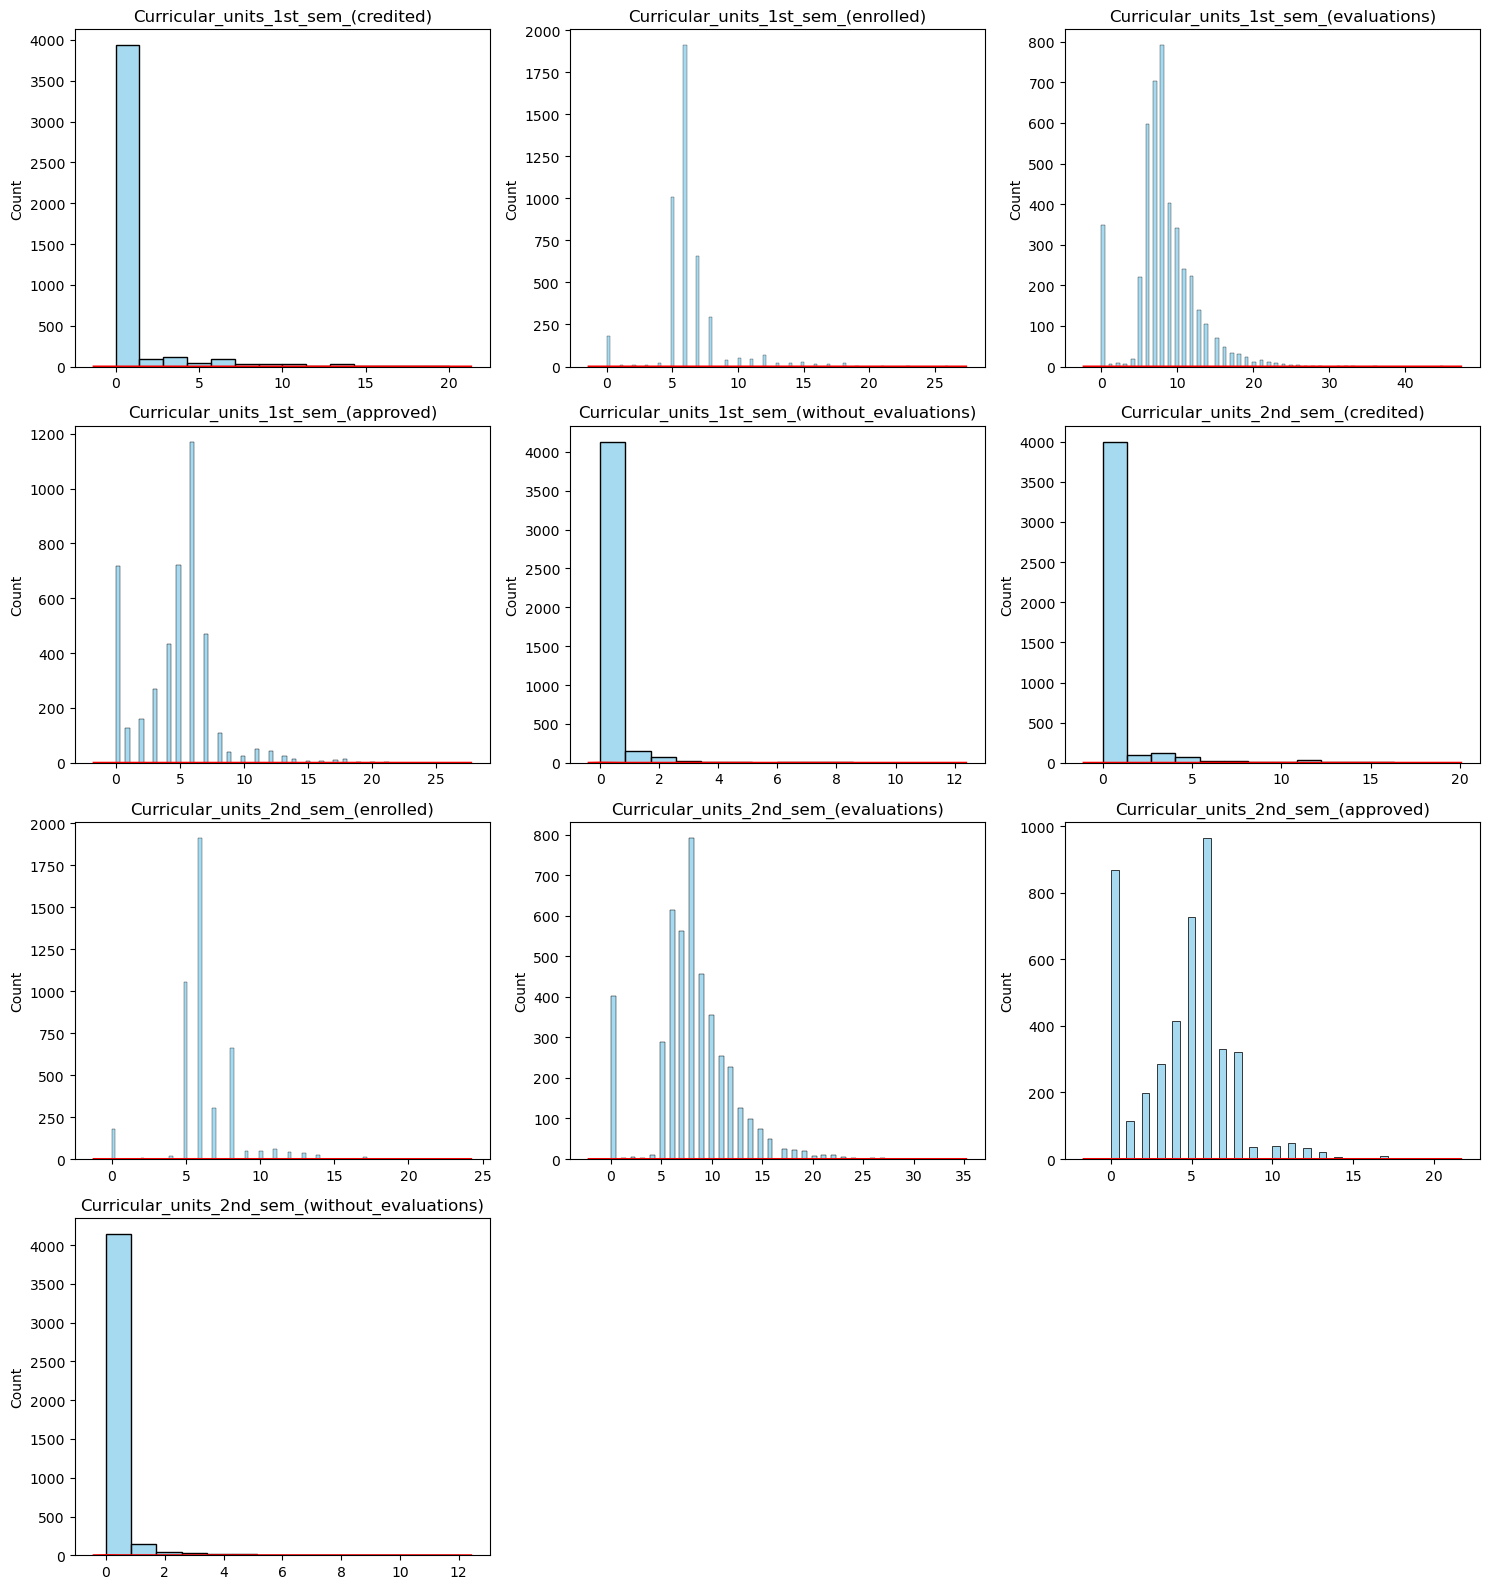

In [18]:

n_cols = 3
n_rows = (len(numeric_cols) - 1) // n_cols + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))

# Flatten the axes array (if 2D)
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(data=df, x=col, ax=axes[i], color='skyblue')
    sns.kdeplot(data=df, x=col, ax=axes[i], color='red')
    axes[i].set_title(col)
    axes[i].set_xlabel('') 

for i in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[i])

fig.tight_layout()

plt.show();


### Some of the features in the student data set present a skewed distribution; it is one where the data values are not symmetrically distributed around the mean. Instead, they tend to trail off more sharply on one side than the other. This can occur due to various factors, including the presence of extreme values or outliers, but skewness can also arise from the inherent characteristics of the data itself.


### Looking for possible outliers in quantitative features

In [19]:

def detect_outliers(df, numeric_columns):
    """
    Identify outliers in specified numerical columns of a DataFrame using the IQR method.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data.
    numeric_columns (list): A list of column names to check for outliers.

    Returns:
    str: A message indicating the number of columns with outliers and the percentage of outliers in each column,
         or a message stating that no columns have outliers.
    """
    
    outlier_dict = {}
    outlier_listing = {}
    counter = 0
    try:
        for column in numeric_columns:
            if column in df.columns:
                Q1 = df[column].quantile(0.25)
                Q3 = df[column].quantile(0.75)
                IQR = Q3 - Q1
            
                # Define the outlier bounds
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
            
                outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
                if len(outliers)> 0:
                # Store outliers in the dictionary
                    #outlier_listing[column]  = outliers.tolist()
                    outlier_dict[column] = round(len(outliers)/df.shape[0],2)#.tolist()
                    counter +=1
                else:
                    print(f"Info: {column} has no outliers.")
    
        #if counter == 0:
         #   return "No columns have outliers."
    
        return "There are {} columns with outliers. Each columns has the following % of outliers: {}".format(counter,outlier_dict)

    except Exception as e:
        return f"An error occurred: {str(e)}"


In [20]:
outlier_table = detect_outliers(df, numeric_cols)
print(outlier_table)

There are 10 columns with outliers. Each columns has the following % of outliers: {'Curricular_units_1st_sem_(credited)': 0.13, 'Curricular_units_1st_sem_(enrolled)': 0.1, 'Curricular_units_1st_sem_(evaluations)': 0.04, 'Curricular_units_1st_sem_(approved)': 0.04, 'Curricular_units_1st_sem_(without_evaluations)': 0.07, 'Curricular_units_2nd_sem_(credited)': 0.12, 'Curricular_units_2nd_sem_(enrolled)': 0.08, 'Curricular_units_2nd_sem_(evaluations)': 0.02, 'Curricular_units_2nd_sem_(approved)': 0.01, 'Curricular_units_2nd_sem_(without_evaluations)': 0.06}


### Looking for possible outliers in categorical features


In [21]:
import pandas as pd

def detect_categorical_outliers(df, categorical_columns, threshold=0.05):
    """
    Identify rare categories in specified categorical columns of a DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data.
    categorical_columns (list): A list of column names to check for rare categories.
    threshold (float): The percentage threshold below which categories are considered outliers.

    Returns:
    dict: A dictionary with column names as keys and lists of rare categories as values,
          or a message stating that no rare categories were found.
    """
    outlier_dict = {}
    counter = 0
    
    try:
        for column in categorical_columns:
            if column in df.columns:

                category_counts = df[column].value_counts(normalize=True)
                
                rare_categories = category_counts[category_counts < threshold].index.tolist()
                
                if rare_categories:
                    outlier_dict[column] = rare_categories
                    counter+=1
                else:
                    print(f"Info: {column} has no outliers.")
        
        if not outlier_dict:
            return "No rare categories found in the specified columns."
        
        return "There is/are {} columns with outliers. Each columns has the following % outlier/s: {}".format(counter,outlier_dict)

    
    except Exception as e:
        return f"An error occurred: {str(e)}"



In [22]:
cat_var = df.select_dtypes(include='object').columns
outlier_table = detect_categorical_outliers(df, cat_var)
print(outlier_table)

Info: Target has no outliers.
No rare categories found in the specified columns.


In [23]:
category_columns = df.select_dtypes(include='category').columns
outlier_table = detect_categorical_outliers(df, category_columns)
print(outlier_table)


Info: Daytime/evening_attendance has no outliers.
Info: Displaced has no outliers.
Info: Debtor has no outliers.
Info: Tuition_fees_up_to_date has no outliers.
Info: Gender has no outliers.
Info: Scholarship_holder has no outliers.
There is/are 13 columns with outliers. Each columns has the following % outlier/s: {'Marital_status': [4, 5, 6, 3], 'Application_mode': [15, 4, 9, 13, 16, 7, 17, 6, 3, 5, 2, 10, 11, 18], 'Application_order': [5, 6, 0, 9], 'Course': [3, 2, 4, 16, 7, 8, 13, 1], 'Previous_qualification': [14, 12, 3, 9, 15, 16, 2, 6, 7, 4, 13, 17, 8, 11, 5, 10], 'Nacionality': [14, 12, 3, 9, 10, 16, 4, 18, 17, 2, 11, 8, 15, 19, 5, 7, 13, 6, 20, 21], "Mother's_qualification": [19, 2, 4, 10, 5, 25, 7, 24, 26, 6, 27, 28, 20, 18, 8, 9, 17, 21, 11, 12, 15, 14, 16, 29], "Father's_qualification": [24, 2, 4, 10, 29, 5, 9, 26, 30, 7, 21, 16, 12, 20, 31, 25, 33, 18, 8, 6, 13, 17, 15, 11, 19, 23, 22, 32, 34], "Mother's_occupation": [1, 2, 7, 12, 9, 29, 13, 32, 20, 15, 22, 30, 28, 11, 19, 3

### Since both quantitaive and qualitative features present outliers, it is essential to carefully assess, handle, and evaluate the impact of these outliers to ensure robust model performance.

In [24]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_df.corr()


In [25]:
correlation_matrix

,Curricular_units_1st_sem_(credited),Curricular_units_1st_sem_(enrolled),Curricular_units_1st_sem_(evaluations),Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(grade),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without_evaluations),Unemployment_rate,Inflation_rate,GDP
Curricular_units_1st_sem_(credited),1.000000,0.774344,0.542919,0.628394,0.122978,0.116262,0.944811,0.644826,0.427845,0.490478,0.132971,0.055256,0.009778,0.023348,-0.026513
Curricular_units_1st_sem_(enrolled),0.774344,1.000000,0.680220,0.769083,0.376996,0.129337,0.753747,0.942627,0.599567,0.673341,0.361959,0.069547,0.038404,0.036758,-0.026262
Curricular_units_1st_sem_(evaluations),0.542919,0.680220,1.000000,0.522396,0.418038,0.241800,0.522187,0.611842,0.778863,0.442265,0.355036,0.134296,0.061545,-0.006604,-0.099761
Curricular_units_1st_sem_(approved),0.628394,0.769083,0.522396,1.000000,0.696113,-0.013360,0.607661,0.733772,0.539934,0.904002,0.685560,-0.053983,0.051286,-0.007114,0.018459
Curricular_units_1st_sem_(grade),0.122978,0.376996,0.418038,0.696113,1.000000,-0.071660,0.113937,0.406167,0.487236,0.673335,0.837170,-0.066076,0.014821,-0.033904,0.054801
Curricular_units_1st_sem_(without_evaluations),0.116262,0.129337,0.241800,-0.013360,-0.071660,1.000000,0.117359,0.109924,0.144683,-0.013070,-0.061482,0.583261,-0.045144,-0.052534,-0.144673
Curricular_units_2nd_sem_(credited),0.944811,0.753747,0.522187,0.607661,0.113937,0.117359,1.000000,0.676258,0.430978,0.519081,0.129770,0.070148,0.010580,0.014490,-0.024491
Curricular_units_2nd_sem_(enrolled),0.644826,0.942627,0.611842,0.733772,0.406167,0.109924,0.676258,1.000000,0.604821,0.703258,0.395135,0.067697,0.064436,0.016844,-0.007592
Curricular_units_2nd_sem_(evaluations),0.427845,0.599567,0.778863,0.539934,0.487236,0.144683,0.430978,0.604821,1.000000,0.463535,0.453394,0.144877,0.045808,-0.012643,-0.004854
Curricular_units_2nd_sem_(approved),0.490478,0.673341,0.442265,0.904002,0.673335,-0.013070,0.519081,0.703258,0.463535,1.000000,0.760804,-0.061567,0.048805,-0.024566,0.022427


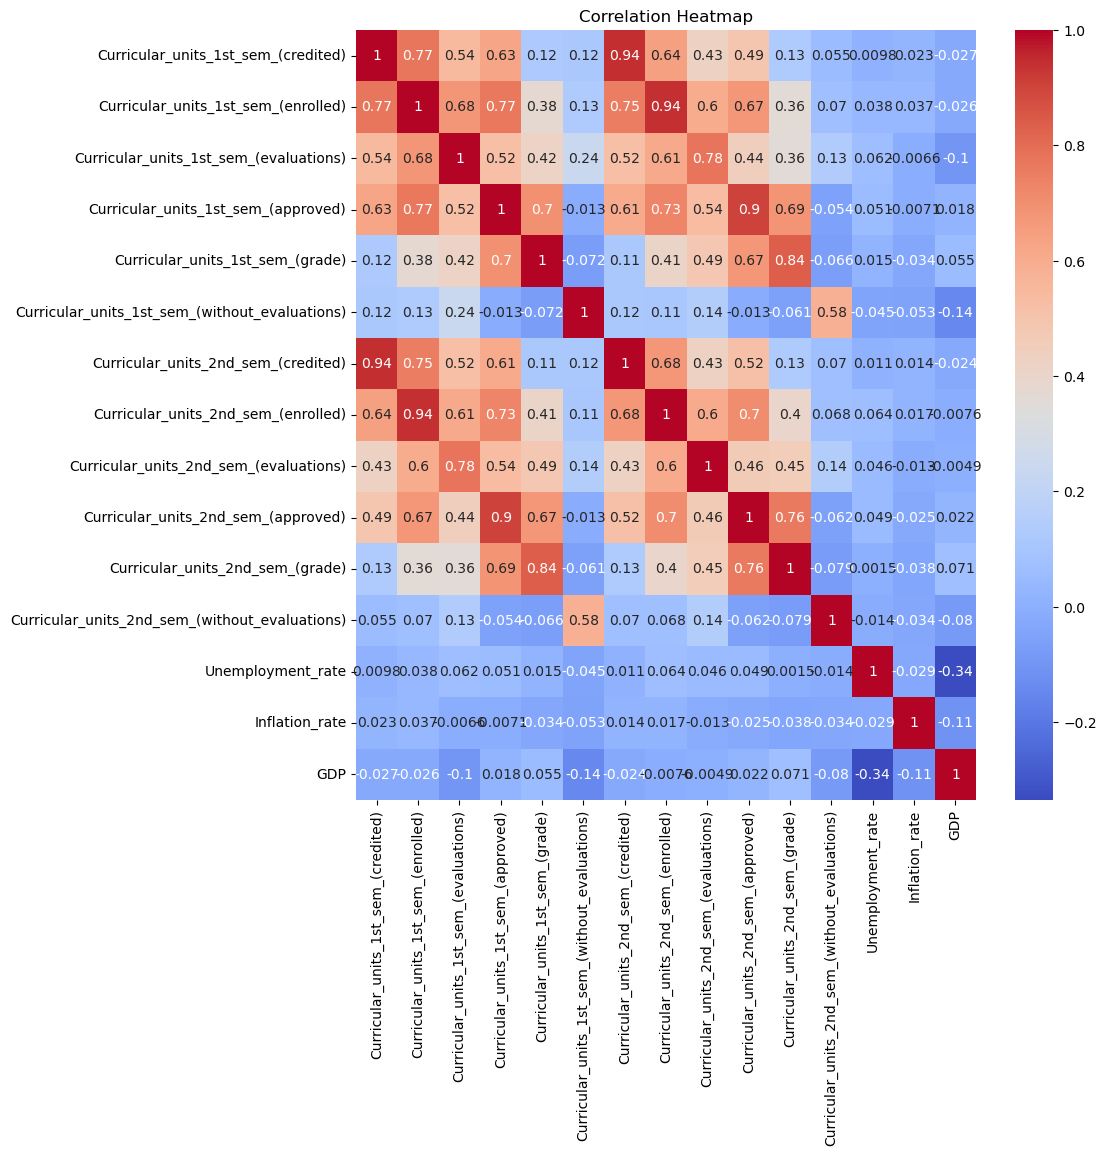

In [26]:
# heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Overall Correlation Strength:
### Some of the correlations in this matrix are strong which provide valuable insights into relationships between variables, but they also come with considerations, especially when building predictive models:


### Let's explore some of the features related to the questions described in the business understanding.

### Question 1 Exploration

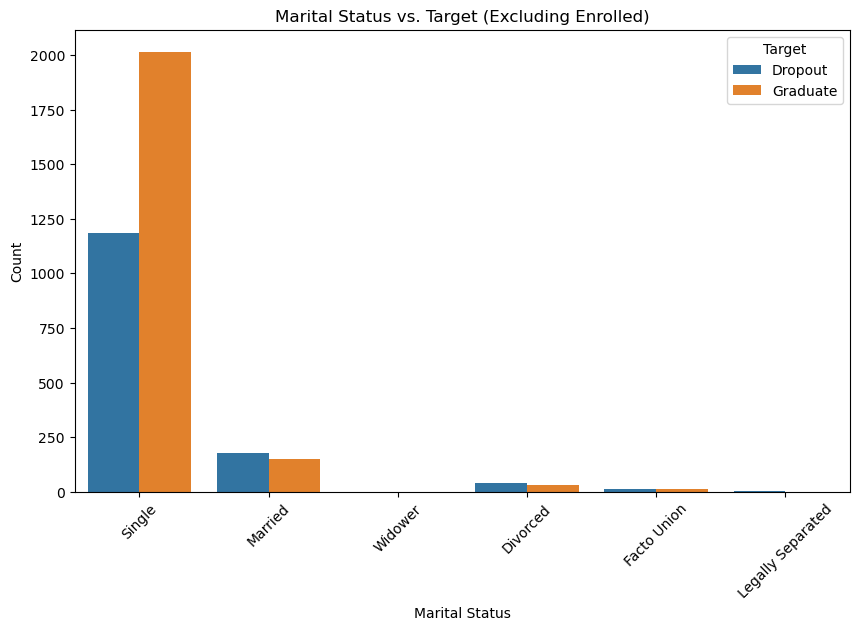

In [27]:
# Marital Status vs Target
# working off of a copy of the origial df to avoid issues

marital_df = df.copy()
marital_status_mapping = {
    1: 'Single',
    2: 'Married',
    3: 'Widower',
    4: 'Divorced',
    5: 'Facto Union',
    6: 'Legally Separated'
}

marital_df['Marital_status'] = marital_df['Marital_status'].map(marital_status_mapping)
marital_filters = marital_df[marital_df['Target'] != 'Enrolled']

marital_status_table = marital_filters.groupby(['Marital_status', 'Target']).size().reset_index(name='Count')

plt.figure(figsize=(10, 6))
sns.barplot(data=marital_status_table, x='Marital_status', y='Count', hue='Target')
plt.title('Marital Status vs. Target (Excluding Enrolled)')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.legend(title='Target')
plt.xticks(rotation=45)
plt.show();


### Question 2 Exploration

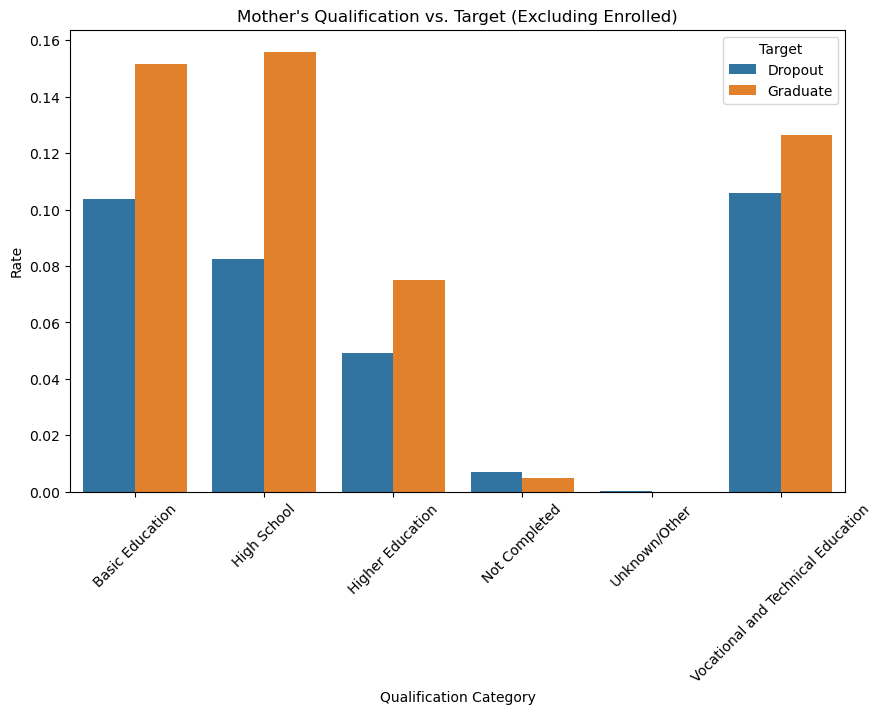

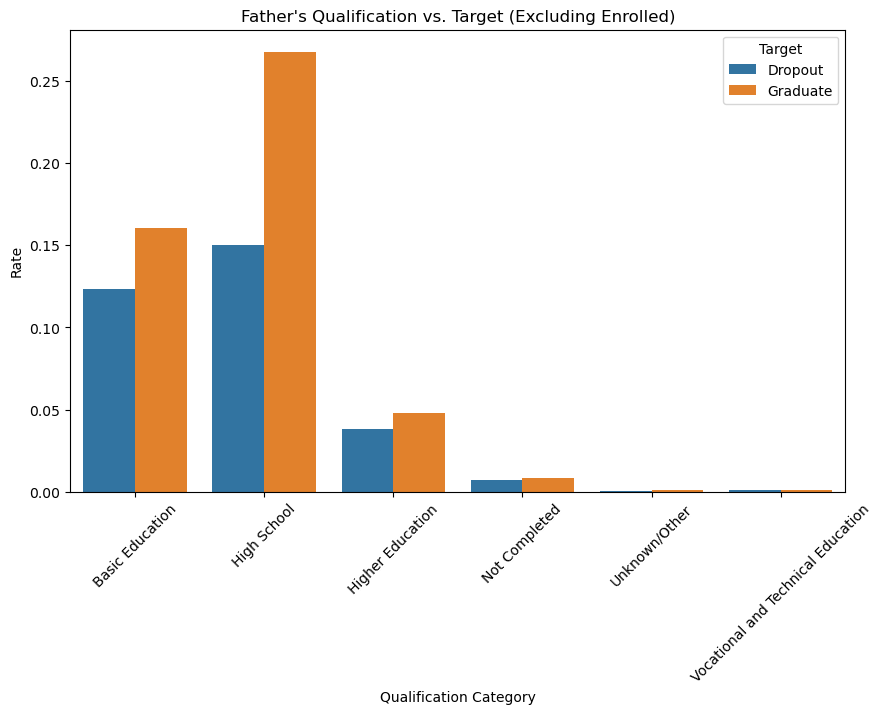

In [28]:
# Parental Qualification vs Target
# working off a copy of the origianl df to avoid issues
parental_qualification_df = df.copy()
qualifications_filter_df = parental_qualification_df[parental_qualification_df['Target'] != 'Enrolled']

# mapping dictionaries for mother's and father's qualifications
qualification_mapping = {
    1: "High School",  # Represents 12th Year of Schooling
    2: "Higher Education",
    3: "Higher Education",
    4: "Higher Education",
    5: "Higher Education",
    6: "Higher Education",
    9: "Not Completed",  # 12th Year of Schooling - Not Completed
    10: "Not Completed",  # 11th Year of Schooling - Not Completed
    11: "Basic Education",  # 7th Year (Old)
    12: "Unknown/Other",
    13: "Basic Education",
    14: "High School",  # 10th Year of Schooling
    18: "Vocational and Technical Education",
    19: "Basic Education",  # Basic Education 3rd Cycle (9th/10th/11th Year) or Equivalent
    20: "Basic Education", 
    22: "Vocational and Technical Education",
    25: "Basic Education",
    26: "Basic Education",
    27: "Basic Education",
    29: "Not Completed",  # 9th Year of Schooling - Not Completed
    30: "Basic Education",
    31: "Vocational and Technical Education",
    33: "Vocational and Technical Education",
    34: "Unknown/Other",
    35: "Unknown/Other",
    36: "Unknown/Other",
    37: "Basic Education",  # Basic Education 1st Cycle (4th/5th year) or Equivalent
    38: "Basic Education",  # Basic Education 2nd Cycle (6th/7th/8th Year) or Equivalent
    39: "Vocational and Technical Education",
    40: "Higher Education",  # Higher education degree (1st cycle)
    41: "Vocational and Technical Education",
    42: "Vocational and Technical Education",
    43: "Higher Education",  # Master's (2nd cycle)
    44: "Higher Education"   # Doctorate (3rd cycle)
}


qualifications_filter_df['Mother_Category'] = qualifications_filter_df["Mother's_qualification"].map(qualification_mapping)
qualifications_filter_df['Father_Category'] = qualifications_filter_df["Father's_qualification"].map(qualification_mapping)


total_rows = qualifications_filter_df.shape[0]

mother_table = (qualifications_filter_df.groupby(['Mother_Category', 'Target']).size().reset_index(name='Count'))
mother_table['Rate'] = mother_table['Count'] / total_rows

father_table = (qualifications_filter_df.groupby(['Father_Category', 'Target']).size().reset_index(name='Count'))
father_table['Rate'] = father_table['Count'] / total_rows

# Mother's Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=mother_table, x='Mother_Category', y='Rate', hue='Target')
plt.title("Mother's Qualification vs. Target (Excluding Enrolled)")
plt.xlabel("Qualification Category")
plt.ylabel("Rate")
plt.legend(title='Target')
plt.xticks(rotation=45)
plt.show()

# Father's Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=father_table, x='Father_Category', y='Rate', hue='Target')
plt.title("Father's Qualification vs. Target (Excluding Enrolled)")
plt.xlabel("Qualification Category")
plt.ylabel("Rate")
plt.legend(title='Target')
plt.xticks(rotation=45)
plt.show()


In [29]:
mother_table

,Mother_Category,Target,Count,Rate
0,Basic Education,Dropout,377,0.103857
1,Basic Education,Graduate,550,0.151515
2,High School,Dropout,300,0.082645
3,High School,Graduate,566,0.155923
4,Higher Education,Dropout,178,0.049036
5,Higher Education,Graduate,273,0.075207
6,Not Completed,Dropout,25,0.006887
7,Not Completed,Graduate,18,0.004959
8,Unknown/Other,Dropout,1,0.000275
9,Vocational and Technical Education,Dropout,384,0.105785


In [192]:
father_table

,Father_Category,Target,Count,Rate
0,Basic Education,Dropout,448,0.123416
1,Basic Education,Graduate,583,0.160606
2,High School,Dropout,545,0.150138
3,High School,Graduate,972,0.267769
4,Higher Education,Dropout,138,0.038017
5,Higher Education,Graduate,174,0.047934
6,Not Completed,Dropout,26,0.007163
7,Not Completed,Graduate,31,0.008540
8,Unknown/Other,Dropout,2,0.000551
9,Unknown/Other,Graduate,3,0.000826


In [30]:
# unique_qualifications = set(qualification_mapping.values())
# len(unique_qualifications)

6

### Question 3 Exploration

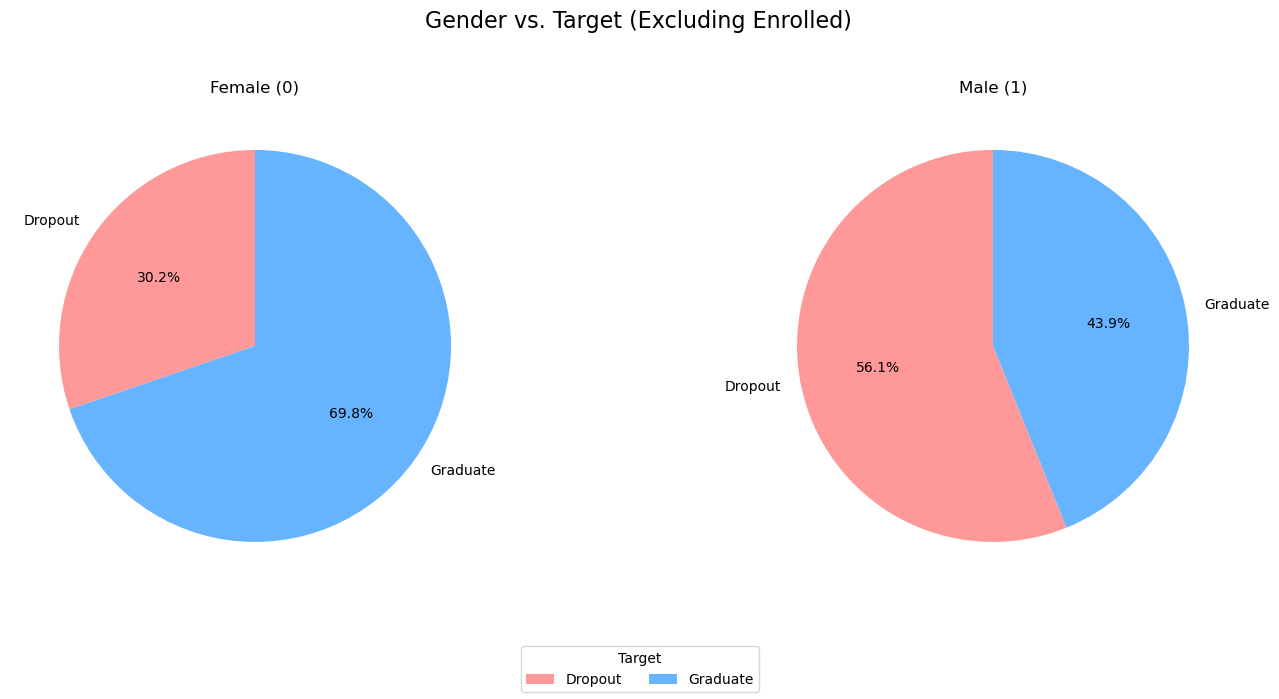

In [31]:
# Gender vs Target
# working off a copy of the origianl df to avoide issues
gender_df = df.copy()


gender_mapping = {0: 'Female', 1: 'Male'}
gender_df['Gender_Label'] = gender_df['Gender'].map(gender_mapping)


gender_table = (gender_df[gender_df['Target'] != 'Enrolled']
                .groupby(['Gender_Label', 'Target'])
                .size()
                .unstack(fill_value=0))


gender_table_percentage = (gender_table.div(gender_table.sum(axis=1), axis=0) * 100)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Gender vs. Target (Excluding Enrolled)', fontsize=16)


colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

# Female plot
ax1.pie(gender_table_percentage.loc['Female'], 
        labels=gender_table_percentage.columns, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=colors)
ax1.set_title('Female (0)')

# Male plot
ax2.pie(gender_table_percentage.loc['Male'], 
        labels=gender_table_percentage.columns, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=colors)
ax2.set_title('Male (1)')


fig.legend(gender_table_percentage.columns, title='Target', loc='lower center', ncol=len(gender_table_percentage.columns))

plt.tight_layout()
plt.subplots_adjust(top=0.85, bottom=0.15)
plt.show();


### Question 4 Exploration

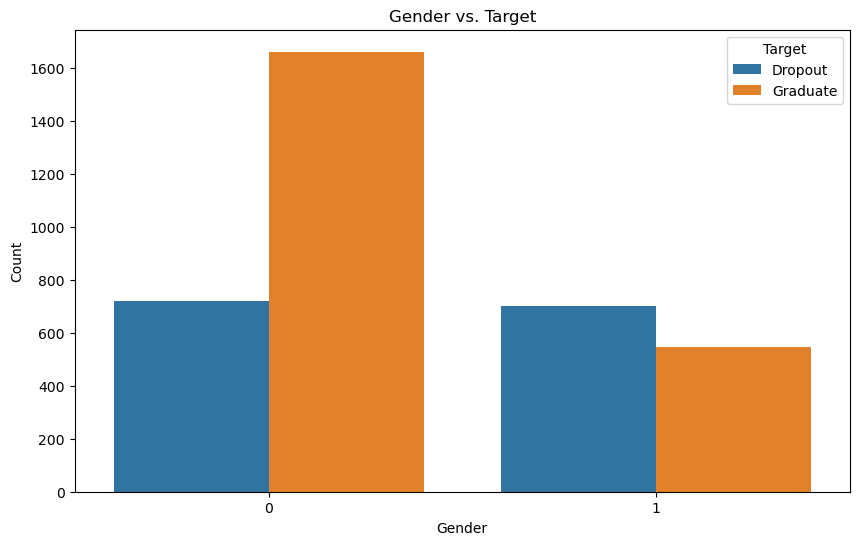

In [205]:


# Gender vs. Target
gender_df = df.copy()
gender_table = gender_df.groupby(['Gender', 'Target']).size().reset_index(name='Count')
gender_table = gender_table[gender_table['Target'] != 'Enrolled']

plt.figure(figsize=(10, 6))
sns.barplot(data=gender_table, x='Gender', y='Count', hue='Target')
plt.title('Gender vs. Target')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Target')
plt.show()



### Overall, marital status, parental education levels, and gender could have some relevance in influencing dropout rates.

## 3.Data Preparation



### The primary goal of this analysis is to explore which features influence student dropouts. Since the target variable has three categories—dropout, graduate, and enrolled—it makes sense to exclude the enrolled category to simplify the analysis process and reduce potential class imbalance.

In [32]:
df_filtered = df[df['Target']!='Enrolled']
df_filtered.head()

,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Nacionality,Mother's_qualification,Father's_qualification,Mother's_occupation,Father's_occupation,Displaced,Educational_special_needs,Debtor,Tuition_fees_up_to_date,Gender,Scholarship_holder,Age_at_enrollment,International,Curricular_units_1st_sem_(credited),Curricular_units_1st_sem_(enrolled),Curricular_units_1st_sem_(evaluations),Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(grade),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without_evaluations),Unemployment_rate,Inflation_rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,10,1,0,0,1,1,0,20,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,4,1,0,0,0,1,0,19,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,10,1,0,0,0,1,0,19,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,4,1,0,0,1,0,0,20,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,10,0,0,0,1,0,0,45,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


### Since Target is now a binary categorical variable, we can use binary encoding.

In [33]:
df_filtered['Target'] = df_filtered['Target'].map({'Dropout': 1, 'Graduate': 0})


In [34]:
df_filtered['Target'].value_counts()

Target
0    2209
1    1421
Name: count, dtype: int64

### The target variable presents a moderate level of class imbalance. To quantify the imbalance ration we divide the number of instance in majority class by the number of instances in minority class. Where the majority class appears to be 1.55 larger times than the minority class. Prior to fitting a ML model, is important to notice that class imbalance can pose challenges as they may become biased towards the majority class. This can lead to poor performance on the minority class.

In [35]:
df_filtered['Target'].value_counts()[0]/df_filtered['Target'].value_counts()[1]

1.5545390570021111

### Creating a function to process data for ML algorithm in the Modeling stage.


In [36]:
# Preprocess the data (One-Hot Encoding for categorical features)
def preprocess_data(df, features):
    """
    Encodes categorical features in a DataFrame using one-hot encoding.

    Args:
        df (pandas.DataFrame): The input DataFrame containing the features.
        features (list): A list of feature names to be encoded.

    Returns:
        pandas.DataFrame: A new DataFrame containing the encoded features.
    """
    
    encoder = OneHotEncoder(drop='first') 
    encoded_features = encoder.fit_transform(df[features])
    feature_names = encoder.get_feature_names_out(features)
    encoded_df = pd.DataFrame(encoded_features.toarray(), columns=feature_names, index=df.index)
    
    return encoded_df

## 4.Data Modeling

### We can now run some statistical test to see if what we observed in the EDA process has a statistical significance. We can leverage a Chi-Square test. This test is a statistical test used to determine if there is a significant association between two categorical variables. It's often used to analyze relationships between variables in contingency tables

In [38]:
def chi_squared_test(df, feature, target):
    """
    Performs a chi-squared test of independence on two categorical variables.

    Args:
        df (pandas.DataFrame): The input DataFrame containing the features and target.
        feature (str): The name of the feature variable.
        target (str): The name of the target variable.

    Returns:
        tuple: A tuple containing the chi-square statistic, p-value, and degrees of freedom.
    """
    contingency_table = pd.crosstab(df[feature], df[target])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    return chi2, p, dof

def calculate_chi_squared_tests(df, features, target):
    """
    Performs chi-squared tests for independence between specified features and a target variable.

    Args:
        df (pandas.DataFrame): The input DataFrame containing the features and target.
        features (list): A list of feature names to be tested.
        target (str): The name of the target variable.

    Returns:
        dict: A dictionary containing the chi-square test results for each feature.
    """
    results = {}
    for feature in features:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            chi2, p, dof = chi_squared_test(df, feature, target)
        
        results[feature] = {'chi2': chi2, 'p-value': p, 'dof': dof}
        print(f'Chi-Squared Test for {feature}:')
        print(f'Chi2: {chi2:.4f}, p-value: {p:.4f}, Degrees of Freedom: {dof}')
        
        # Significance Level
        alpha = 0.05  
        if p < alpha:
            print(f"The association between {feature} and {target} is statistically significant (p < {alpha}).")
        else:
            print(f"There is no statistically significant association between {feature} and {target} (p >= {alpha}).")
        
        print()  
    
    return results

features = ["Marital_status", "Father's_qualification", "Mother's_qualification", "Gender"]


chi_squared_results = calculate_chi_squared_tests(df_filtered, features, 'Target')

# results sorted by chi-squared statistic
sorted_results = sorted(chi_squared_results.items(), key=lambda x: x[1]['chi2'], reverse=True)
print("\nFeatures sorted by chi-squared statistic:")
for feature, result in sorted_results:
    print(f"{feature}: Chi2 = {result['chi2']:.4f}, p-value = {result['p-value']:.4f}")


Chi-Squared Test for Marital_status:
Chi2: 53.1314, p-value: 0.0000, Degrees of Freedom: 5
The association between Marital_status and Target is statistically significant (p < 0.05).

Chi-Squared Test for Father's_qualification:
Chi2: 147.8617, p-value: 0.0000, Degrees of Freedom: 33
The association between Father's_qualification and Target is statistically significant (p < 0.05).

Chi-Squared Test for Mother's_qualification:
Chi2: 143.0143, p-value: 0.0000, Degrees of Freedom: 28
The association between Mother's_qualification and Target is statistically significant (p < 0.05).

Chi-Squared Test for Gender:
Chi2: 229.3515, p-value: 0.0000, Degrees of Freedom: 1
The association between Gender and Target is statistically significant (p < 0.05).


Features sorted by chi-squared statistic:
Gender: Chi2 = 229.3515, p-value = 0.0000
Father's_qualification: Chi2 = 147.8617, p-value = 0.0000
Mother's_qualification: Chi2 = 143.0143, p-value = 0.0000
Marital_status: Chi2 = 53.1314, p-value = 0.00

### The Chi-Squared tests conducted on the dataset show that all four features — Marital Status, Father's Qualification, Mother's Qualification, and **Gender — have statistically significant associations with the target variable. The p-values for each feature are below 0.05, indicating that the relationships observed are unlikely to be due to random chance.Among the features, Gender had the strongest association with the target, as indicated by the highest Chi-Squared statistic (229.35), followed by Father's Qualification (147.86) and Mother's Qualification (143.01). Marital Status showed a very weak, yet still significant, association (53.13).  

### Next we can perform a Cramer's V which is a measure of association between two nominal variables that can quantify the strenght of the relationship between two variables.International has no association with Target so it will not be included in the next test.

In [46]:



def cramers_v(confusion_matrix):
    """
    Calculates Cramer's V, a measure of association between two categorical variables.

    Args:
        confusion_matrix (pandas.DataFrame): The confusion matrix representing the observed frequencies.

    Returns:
        float: The calculated Cramer's V value.
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

def calculate_association_for_features(df, features, target):
    """
    Calculates the appropriate association measure (Phi coefficient or Cramer's V) for each specified feature with the target variable.

    Args:
        df (pandas.DataFrame): The input DataFrame containing the features and target.
        features (list): A list of feature names to be evaluated.
        target (str): The name of the target variable.

    Returns:
        dict: A dictionary containing the calculated association measures for each feature.
    """
    results = {}
    
    for feature in features:
        contingency_table = pd.crosstab(df[feature], df[target])
        
        if df[feature].nunique() == 2 and df[target].nunique() == 2:
            # binary variables with Phi coefficient
            chi2 = chi2_contingency(contingency_table)[0]
            n = contingency_table.sum().sum()
            phi = np.sqrt(chi2 / n)
            results[feature] = phi
            print(f"Phi coefficient for {feature}: {phi:.4f}")
        else:
            # multi-category variables Cramér's V
            cramer_v = cramers_v(contingency_table)
            results[feature] = cramer_v
            print(f"Cramér's V for {feature}: {cramer_v:.4f}")
    
    return results


features = ["Marital_status", "Father's_qualification", "Mother's_qualification", "Gender"]
target = 'Target'


association_results = calculate_association_for_features(df_filtered, features, target)

sorted_results = sorted(association_results.items(), key=lambda x: abs(x[1]), reverse=True)
print("\nFeatures sorted by association strength:")
for feature, value in sorted_results:
    print(f"{feature}: {value:.4f}")


Cramér's V for Marital_status: 0.1210
Cramér's V for Father's_qualification: 0.2018
Cramér's V for Mother's_qualification: 0.1985
Phi coefficient for Gender: 0.2514

Features sorted by association strength:
Gender: 0.2514
Father's_qualification: 0.2018
Mother's_qualification: 0.1985
Marital_status: 0.1210


### The Cramér's V and Phi coefficient tests reveal varying strengths of association between the categorical features and the target variable. Gender exhibits the strongest association with a Phi coefficient of 0.2514, indicating a moderate relationship. Both Father's Qualification (Cramér's V = 0.2018) and Mother's Qualification (Cramér's V = 0.1985) also show moderate associations with the target, while Marital Status has the weakest association (Cramér's V = 0.1210), suggesting a relatively weaker connection. These results highlight that Gender plays the most significant role in influencing the target, followed by parental qualifications, with marital status having a comparatively smaller impact.

## 5.Modeling

### We can create a model that uses the four features (Gender, Father's Qualification, Mother's Qualification, and Marital Status) to predict the target.

### Logistic Regression

In [43]:
# features selection

features = ["Gender", "Father's_qualification", "Mother's_qualification", "Marital_status"]
target = 'Target'
df_log = df_filtered.copy()
# processing features of interest
X = preprocess_data(df_log, features)
y = df_log[target]
# splitting data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# fitting logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42,class_weight='balanced')
model.fit(X_train, y_train)

# predicting on test data
y_pred = model.predict(X_test)

# logistic regression model performance
accuracy_logistic_regression_model = accuracy_score(y_test, y_pred)
print(f"Accuracy for logistic regression model: {accuracy_logistic_regression_model:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy for logistic regression model: 0.6465

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.69      0.71       675
           1       0.53      0.58      0.55       414

    accuracy                           0.65      1089
   macro avg       0.63      0.63      0.63      1089
weighted avg       0.65      0.65      0.65      1089



### We observed the Target variable has a moderate level of class imbalance which migt be the reasong why the model has lower performance on minority class. We can try the SMOTE (Synthetic Minority Over-sampling Technique) or other models like XGBoost to handle the class imbalance.

### SMOTE Approach 


In [44]:

features = ["Gender", "Father's_qualification", "Mother's_qualification", "Marital_status"]
target = 'Target'
df_smote = df_filtered.copy()
# processing features of interet
X = preprocess_data(df_smote, features)
y = df_smote[target]
# splitting data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE for minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
#
# fitting regression model
model = LogisticRegression(random_state=42)
model.fit(X_resampled, y_resampled)

# predicting on test data 
y_pred = model.predict(X_test)

# SMOTE implementation evaluation 
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for SMOTE implemenation: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy for SMOTE implemenation: 0.6483

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.70      0.71       675
           1       0.54      0.57      0.55       414

    accuracy                           0.65      1089
   macro avg       0.63      0.63      0.63      1089
weighted avg       0.65      0.65      0.65      1089



#### XGBoost Implementation

In [45]:

features = ["Marital_status", "Father's_qualification", "Mother's_qualification", "Gender"]
target = 'Target'
df_xgboost = df_filtered.copy()
# processing features of interest
X = preprocess_data(df_xgboost, features)
y = df_xgboost[target]  


# splitting data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# XGBoost
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'eval_metric': 'logloss'
}

# fitting the XGBoost model
xg_model = xgb.train(params, dtrain, num_boost_round=100)

# predicting on test data
y_pred = xg_model.predict(dtest)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

# XGBoost implementation evaluation 
accuracy = accuracy_score(y_test, y_pred_binary)
report = classification_report(y_test, y_pred_binary)


print(f"Accuracy for XGBoost Model: {accuracy:.4f}")
print("Classification Report:")
print(report)


Accuracy for XGBoost Model: 0.6657
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75       675
           1       0.58      0.44      0.50       414

    accuracy                           0.67      1089
   macro avg       0.64      0.62      0.62      1089
weighted avg       0.65      0.67      0.65      1089



## 5.Evaluation

## Model Evaluation Summary

| Model                  | Accuracy | Precision (0) | Recall (0) | F1-score (0) | Precision (1) | Recall (1) | F1-score (1) |
|------------------------|----------|----------------|-------------|----------------|----------------|-------------|----------------|
| Logistic Regression     | 0.6465   | 0.73           | 0.69        | 0.71           | 0.53           | 0.58        | 0.55           |
| SMOTE Implementation    | 0.6483   | 0.73           | 0.70        | 0.71           | 0.54           | 0.57        | 0.55           |
| XGBoost                 | 0.6657   | 0.70           | 0.81        | 0.75           | 0.58           | 0.44        | 0.50           |





#### Based on the evaluation results, XGBoost is the most favorable model to use for the following reasons:

- Highest Accuracy: XGBoost achieved an accuracy of 0.6657, which is the highest among the models tested. This indicates it has a better overall performance in predicting the target variable.

- Better Recall for Class 0: The recall for class 0 is 0.81, which means XGBoost is effective at correctly identifying most of the negative instances. 

- Reasonable Precision for Class 1: Although the precision and recall for class 1 are lower compared to the recall for class 0, the model still maintains a balance that may be acceptable depending on the context of the problem.

- Robustness: XGBoost is known for its robustness and ability to handle complex relationships in data. It typically performs well with structured data and can manage categorical variables effectively, especially when combined with techniques like one-hot encoding.



## 6.Deployment

### While XGboost shows good performance, it would be beneficial to explore additional features before deploying the model. Apart from further features exploration and considering different algorithms, engaging with domain experts can lead to the discovery of valuable features that could improve the model's effectiveness.